<a href="https://colab.research.google.com/github/sugi-san/Wav2Lip/blob/master/Wav2Lip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

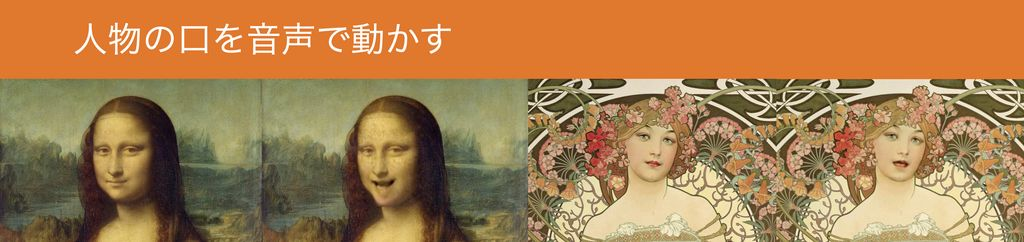

In [ ]:
#@title 1.セットアップ（数分程度かかります）
from IPython.utils import io
import os
import subprocess
import tqdm.notebook

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:

      # githubからコードを取得
      ! git clone https://github.com/sugi-san/Wav2Lip.git
      %cd Wav2Lip
      pbar.update(5)

      # ライブラリ・インストール
      ! pip install -r requirements.txt
      pbar.update(35)
      
      # 学習済みパラメータのダウンロード
      import gdown
      gdown.download('https://drive.google.com/uc?id=195RPsqXVhfh4QyCnaDQdf56KrGk20AUq', 'checkpoints.zip', quiet=False)
      ! unzip checkpoints.zip
      ! wget "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" -O "face_detection/detection/sfd/s3fd.pth"
      pbar.update(10)

      # 音声パッケージ
      !pip install -qq pydub
      !apt-get -qq update
      !apt-get -qq install -y ffmpeg
      pbar.update(5)

      # ml4aインストール
      %tensorflow_version 1.x
      !pip3 install --quiet ml4a
      pbar.update(25)

      # 初回変換
      from ml4a import audio
      from ml4a import image
      from ml4a.models import wav2lip
      input_image = image.monalisa()
      input_audio, sample_rate = audio.sample_audio()
      wav2lip.run(input_image, 
                  input_audio,
                  sampling_rate = sample_rate,
                  output_video = 'output.mp4', 
                  pads = [0, 10, 0, 0],
                  resize_factor = 2, 
                  crop = None, 
                  box = None)
      pbar.update(20)

except subprocess.CalledProcessError:
  print(captured)
  raise



# サンプリング・レート取得
def get_rate(file_path):
    import wave
    wf = wave.open(file_path, "r")
    fs = wf.getframerate()
    return fs

# 画像表示
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
%matplotlib inline

def display_pic(folder):
    fig = plt.figure(figsize=(20, 40))
    files = os.listdir(folder)
    files.sort()
    for i, file in enumerate(files):
        if file=='.ipynb_checkpoints':
           continue
        img = Image.open(folder+'/'+file)    
        images = np.asarray(img)
        ax = fig.add_subplot(10, 5, i+1, xticks=[], yticks=[])
        image_plt = np.array(images)
        ax.imshow(image_plt)
        ax.set_xlabel(file, fontsize=20)               
    plt.show()
    plt.close() 

# ファイル表示
def display_file(folder):
    files = sorted(os.listdir(folder))
    for file in files:
        if file =='.ipynb_checkpoints': 
          continue
        print(file)

# 録音
import base64
import google.colab
import pydub

from io import BytesIO

def record_audio(file_id='out', framerate=16000, file_format='flac'):
  # Record webm file from Colaboratory.
  audio = google.colab._message.blocking_request(
    'user_media',
    {
      'audio': True,
      'video': False,
      'duration': -1
    },
    timeout_sec=600)

  # Convert web file into in_memory file.
  mfile = BytesIO(base64.b64decode(audio[audio.index(',')+1:]))

  # Store webm file locally.
  with open('{0}.webm'.format(file_id), 'wb') as f:
    mfile.seek(0)
    f.write(mfile.read())

  # Open stored web file and save it as wav with sample_rate=16000
  output_file = '{0}.{1}'.format(file_id, file_format)
  _ = pydub.AudioSegment.from_file('{0}.webm'.format(file_id), codec='opus')
  _.set_frame_rate(16000).export(output_file, format=file_format)

  return output_file        

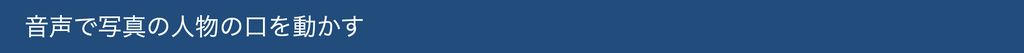

In [ ]:
#@title 2.写真と音声の表示
print('=== image ===')
display_pic('image')
print('=== audio ===')
display_file('audio')

In [ ]:
#@title 3.動画の作成
image = '004.jpg' #@param {type:"string"}
audio ='conbini.wav' #@param {type:"string"}
image_path = 'image/'+image
audio_path = 'audio/'+audio
rate = get_rate(audio_path)
chin = 10 #@param {type:"slider", min:0, max:60, step:10}

wav2lip.run(image_path, 
            audio_path,
            sampling_rate = rate,
            output_video = 'output.mp4', 
            pads = [0, chin, 0, 0],
            resize_factor = 2, 
            crop = None, 
            box = None) 

In [ ]:
#@title 4.動画の再生
from IPython.display import HTML
from base64 import b64encode

mp4 = open('output.mp4', 'rb').read()
data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
HTML(f"""
<video width="50%" height="50%" controls>
      <source src="{data_url}" type="video/mp4">
</video>""")

In [ ]:
#@title 5.動画のダウンロード
import shutil
image_name = os.path.splitext(image)
audio_name = os.path.splitext(audio)
download_name = image_name[0]+'_'+audio_name[0]+'.mp4'
shutil.copy('output.mp4', download_name)

from google.colab import files
files.download(download_name)

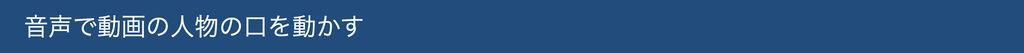

In [ ]:
#@title 6.動画と音声の表示
print('=== video ===')
display_file('video')
print('=== audio ===')
display_file('audio')

In [ ]:
#@title 7.動画の作成
video = 'koike.mp4'#@param {type:"string"}
audio = 'tenki.wav'#@param {type:"string"}
video_path = 'video/'+video
audio_path = 'audio/'+audio
chin = 10 #@param {type:"slider", min:0, max:60, step:10}
pads = '0 '+str(chin)+' 0 0'
! python inference.py --checkpoint_path checkpoints/wav2lip_gan.pth\
                      --face $video_path\
                      --audio $audio_path\
                      --pads $pads

In [ ]:
#@title 8.動画の再生
from IPython.display import HTML
from base64 import b64encode
mp4 = open('results/result_voice.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width="70%" height="70%" controls>
      <source src="{data_url}" type="video/mp4">
</video>""")

In [ ]:
#@title 9.動画のダウンロード
import os
import shutil
from google.colab import files

video_name = os.path.splitext(video)
audio_name = os.path.splitext(audio)
file_name = 'results/'+video_name[0]+'_'+audio_name[0]+'.mp4'
shutil.copy('results/result_voice.mp4', file_name)
files.download(file_name)

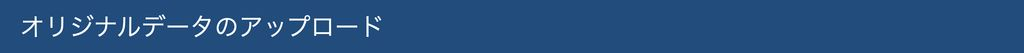

In [ ]:
#@title 10.データアップロード
#@markdown ・音声はwav, 写真はjpg, 動画はmp4が対象です
import os
import shutil
from google.colab import files
import cv2

select = 'audio' #@param ["audio", "image", "video"]

# ルートへ画像をアップロード
uploaded = files.upload()           
uploaded = list(uploaded.keys())    

# ルートから指定フォルダーへ移動
for file in uploaded:
    shutil.move(file, select+'/'+file)  

In [ ]:
#@title 11.音声を録音してアップロード
#@markdown　・my.wavとしてアップロードされます
from pydub import AudioSegment
from IPython.display import Audio

# 録音（結果はout.flacに保存）
record_audio()

# out.flacをモノラルmy.wavに変換
sound = AudioSegment.from_file("out.flac", "flac")
mono_sound = sound.set_channels(1)
mono_sound.export("./audio/my.wav", format="wav", bitrate="16k")

# my.wavを再生
Audio("./audio/my.wav", rate=16000)

###【備考】
・ブラウザは、必ずGoogle Chromeを使用して下さい。

・動作がおかしくなった場合の対応\
１）グーグルクロームの該当タブを削除して接続を切る\
２）再度リンクを開く\
３）右上にある「ランタイム／ランタイムを出荷時設定にリセット」をクリックする（下記写真を参照に下さい）\
４）あとは、動画にある通りの操作をすればOK

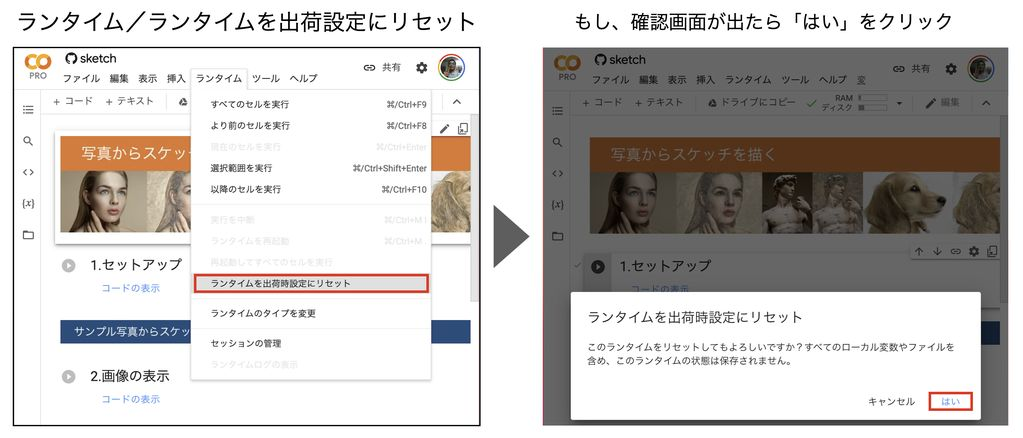